In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


## Downlaod MNSIT

In [10]:
# Binarize MNIST dataset
def binarize_data(x):
    return (x > 0.5).float()

# Load MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(binarize_data)  # Binarize the data
])

train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)



# Bernoulli VAE

## Define Model

In [11]:
class BernoulliVAE(nn.Module):
    def __init__(self, latent_dim=40):
        super(BernoulliVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


In [12]:
def bernoulli_loss(recon_x, x, mu, logvar):
    # Reconstruction loss
    bce = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')

    # KL Divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return bce + kl_div


## Train Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 40
bernoulli = BernoulliVAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(bernoulli.parameters(), lr=1e-3)

epochs = 50
bernoulli.train()
for epoch in range(epochs):
    train_loss = 0
    for batch in train_loader:
        data, _ = batch
        data = data.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = bernoulli(data)
        loss = bernoulli_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")


# Gauusian VAE

## Define Model

In [ ]:
class GaussianVAE(nn.Module):
    def __init__(self, latent_dim=40, sigma=0.1):
        super(GaussianVAE, self).__init__()
        self.latent_dim = latent_dim
        self.sigma = sigma  # Fixed σ, or replace this with a learnable parameter

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28)  # Directly output mean μ of Gaussian
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [ ]:
def gaussian_loss(recon_x, x, mu, logvar, sigma=0.1):
    # Reconstruction loss (Gaussian negative log-likelihood)
    recon_loss = torch.sum((x.view(-1, 28 * 28) - recon_x) ** 2) / (2 * sigma ** 2)

    # KL Divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_div


## Train Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 40
sigma = 0.1  # You can experiment with different values
gaussian = GaussianVAE(latent_dim=latent_dim, sigma=sigma).to(device)
optimizer = optim.Adam(gaussian.parameters(), lr=1e-3)

epochs = 20
gaussian.train()
for epoch in range(epochs):
    train_loss = 0
    for batch in train_loader:
        data, _ = batch
        data = data.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = gaussian(data)
        loss = gaussian_loss(recon_batch, data, mu, logvar, sigma)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")


# Show Results

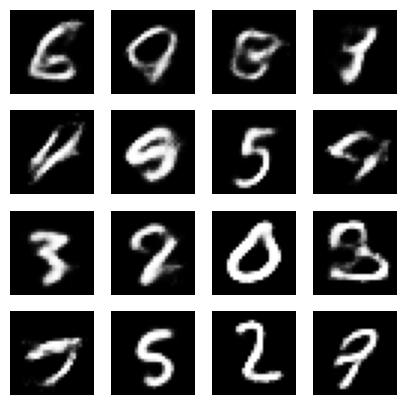

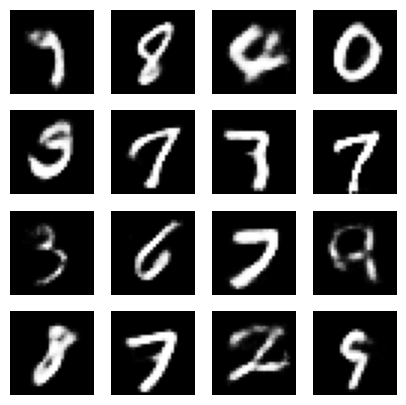

In [ ]:
# ----- Bernoulli -----
bernoulli.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    samples = bernoulli.decode(z).view(-1, 1, 28, 28).cpu()

    # Plot generated samples
    plt.figure(figsize=(5, 5))
    for i, img in enumerate(samples[:16]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

# ----- Gaussian -----
gaussian.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    samples = gaussian.decode(z).view(-1, 1, 28, 28).cpu()

    # Plot generated samples
    plt.figure(figsize=(5, 5))
    for i, img in enumerate(samples[:16]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()
